## Analysis I: engineering perspective

# 1- Setup

Import some python modules and set the working directory to where the .py are located

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Set the working directory where the py modules are placed
#os.chdir('projects/Cavitazione.pompa.exp/py/')

# Path to datasets
path_to_DS = '/Users/csartori/dati/pump_cavitation/data-raw/DS1'
air_in = 4
air_no = 0
air_stand = 5
show = air_in

Create a list with the path to each file of the first dataset (DS1)

In [2]:
DS = [os.path.join(path_to_DS, f) for f in os.listdir(path_to_DS)]
# os.listdir() produces the list of filenames in arbitrary order, 
#.   therefore it must be sorted, since the filenames contain 
#.   the starting timestamp
DS.sort()

# 2- Read the DS1 file corresponding to "AIR IN" 

Hint: load the python module read_bin and store each record as a list element

In [3]:
import read_bin as rb

file_struct = rb.ptr_record(DS[show])

# Init data list
data = []

for record in file_struct[:, 0]:
    data.append(rb.read_record(DS[show], record))


In [4]:
data[0][1].shape

(75000, 6)

Describe the structure of data

In [5]:
print(len(data))

print(len(data[0]))

# Timestamp
print(data[0][0])

# Raw signals: P1_x, P1_y, P1_z, P2_x, P2_y, P2_z.
print(data[0][1])

71
2
2013-01-10 08:47:53.343000
[[ 1.80972     6.7978945   0.46692607  0.86366063  1.1108568   0.8972305 ]
 [ 2.5238423   3.1586175  -0.20447089  0.35706112 -0.58899826 -2.1011672 ]
 [ 1.9577326   0.5004959  -1.107805    0.2746624  -2.1881437  -1.9851987 ]
 ...
 [-0.84992754  2.3544672   0.18921188 -0.21972992  2.7344167   0.4303044 ]
 [-1.4587625   2.5223162   0.64698255 -0.11749447 -2.543679   -1.0879682 ]
 [-1.1490043   1.1825742   0.30212864  2.1866179  -2.2674906  -3.387503  ]]


In [6]:
sg_labels = ['P1_x', 'P1_y', 'P1_z', 'P2_x', 'P2_y', 'P2_z']

# 3- Plot the data 

Hint: transform the "data" list to a numpy array, call it "signals"

In [7]:
# Init data array
n_points = 75000
n_records = len(data)

signals = np.zeros((n_points * n_records, 6), float)

# Store data as a single array
i = 0
for item in data: # each item is a list of two elements, the timestamp and the data
    signals[i:(i + n_points), :] = item[1]
    i += n_points

In [8]:
signals.shape

(5325000, 6)

#### Now plot the signals 
You can define a loop on the columns of signals and plot them separately

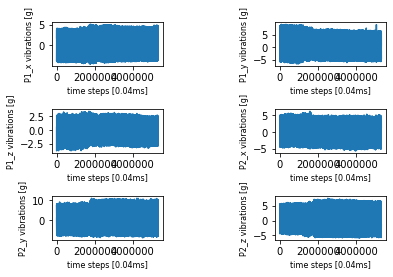

In [9]:
nplot = signals.shape[1]
plt.subplots_adjust(hspace=1, wspace=1)
for i in range(1,nplot+1):
    plt.subplot(nplot/2,2,i)
    plt.plot(signals[:,i-1])
    plt.ylabel(sg_labels[i-1]+' vibrations [g]',fontsize=8)
    plt.xlabel('time steps [0.04ms]',fontsize=8)
    

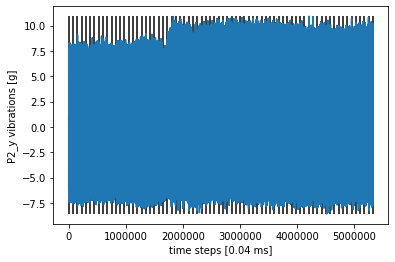

In [10]:
# old version with single plot, changed in to fill version

# Signals is an array with 6 columns, P1_x, P1_y, P1_z, P2_x, P2_y, P2_z.
# Plot P2_y data
P2_y = signals[:, 4]

# Place a vertical line corresponding to the end of each data record
vline_coord = np.arange(0, n_points * (n_records + 1), n_points)

plt.plot(P2_y)
plt.vlines(vline_coord, ymin=P2_y.min(), ymax=P2_y.max())
plt.ylabel('P2_y vibrations [g]')
plt.xlabel('time steps [0.04 ms]')
plt.show()

Visualize also the other signals of P1 and P2

# 4- Compute the power band of one record

Hint: use the power_band function contained in the power_band.py module

In [11]:
import power_band as pwr

signals = data[0][1]

pwr.power_band(signals)

array([ 79.8569 , 398.635  , 129.689  , 353.8285 , 711.3408 , 325.71466],
      dtype=float32)

A call to power_band on signals returns an array with 6 elements, corresponding to the power bands between 2.5 and 5 kHz of the 3 secs signals of P1_x, P1_y, P1_z, P2_x, P2_y, P2_z.  

# 5- Read and compute the power band of all the DS1 data

Hint: use the power_band function and store the results in a convenient format. For instance nested lists:

In [12]:
# ...it takes some time...
ds_pwr_band = []

for File in DS:
    record_pwr = []
    file_struct = rb.ptr_record(File)
    for record in file_struct[:, 0]:
        data = rb.read_record(File, record)
        timestamp = data[0]
        pwr_band = pwr.power_band(data[1])
        record_pwr.append([timestamp, pwr_band])

    ds_pwr_band.append(record_pwr)

In [13]:
[len(r) for r in ds_pwr_band]

[11, 95, 130, 60, 71, 237, 433]

In [14]:
print(ds_pwr_band[0][2][0])

2013-01-10 08:28:41.281000


# 6- Plot the DS1 power bands

1. transform the ds_pwr_band to an array, named DS_pwr
    - The timestaps will be omitted
2. be prepared to plot vertical lines in correspondance of each
   file 
   - count the number of records in each file
   - the cumulatives of the counts will be the x coordinates of the lines

In [15]:
DS_pwr = []

for File in ds_pwr_band:
    DS_pwr_per_file = []
    for record in File:
        DS_pwr_per_file.append(record[1])

    DS_pwr.append(DS_pwr_per_file)

Now DS_pwr has the following structure:

In [16]:
#DS1[0] / RECORD_00_POWER_BAND
#         ...
#       / RECORD_XX_POWER_BAND
#         ...
#DS1[6] / RECORD_00_POWER_BAND
#         ...
#       / RECORD_XX_POWER_BAND

In [17]:
# Keep track of the number of records in each file...
DS_vline_dist = np.asarray([len(item) for item in DS_pwr])
# ...that will be used to place vertical lines in the plot,
# corresponding to the end of each file

In [18]:
print(DS_vline_dist)

[ 11  95 130  60  71 237 433]


In [19]:
DS_vline_coord = np.cumsum(DS_vline_dist)
print(DS_vline_coord)

[  11  106  236  296  367  604 1037]


In [20]:
# i = 1
# while i < len(DS_vline_coord):
#     DS_vline_coord[i] += DS_vline_coord[i - 1]
#     i += 1

In [21]:
# Create an array with power bands
pwr_band = []
for item in DS_pwr:
    for pwr in item:
        pwr_band.append(pwr)
        

pwr_band = np.asarray(pwr_band)

In [22]:
pwr_band.shape

(1037, 6)

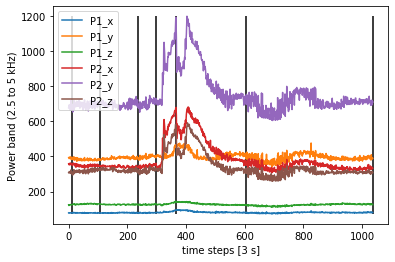

In [23]:
# Plot all the six power bands
for i in range(pwr_band.shape[1]):
    plt.plot(pwr_band[:,i], label=sg_labels[i])
plt.legend()
plt.vlines(DS_vline_coord, ymin=pwr_band.min(), ymax=pwr_band.max())
plt.ylabel('Power band (2.5 to 5 kHz)')
plt.xlabel('time steps [3 s]')
plt.show()

Which one is the most significant? 

Can you imagine a method to find the most significant power band, beside just ___looking___ at the plots?

# 7- Threshold-based alarms 

Let's say that the XX power band is the most significant 

From an engineering perspective you are likely to be told that the pump can tolerate vibrations only up to a certain amount. For instance, if the XX
power band raises above 15% of its mean value in good working condition then an alarm should be generated.

In [24]:
thrPerc = 0.15 # threshold (in percentage)
top = 4 # index of the most interesting power band
Top_pwr = pwr_band[:, top]

# Last data entry before introducing air in the pump
stop_index = DS_vline_coord[3]

mean_Top_pwr = np.mean(Top_pwr[:stop_index])

threshold = mean_Top_pwr * (thrPerc + 1)

How many occurences in this simple decision stump?

In [25]:
alarms = Top_pwr > threshold
n_alarms = sum(alarms)
percentage = n_alarms / len(alarms)
'Percentage of alarms {:2.2%}'.format(percentage)

'Percentage of alarms 16.01%'

# 8- Visualize the decision stump

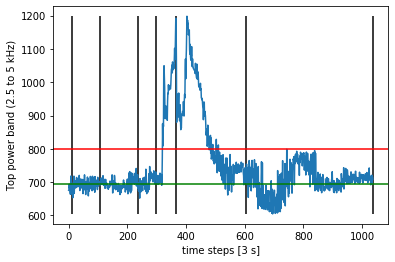

In [26]:
plt.plot(Top_pwr)
plt.axhline(y = mean_Top_pwr, color='green')
plt.axhline(y = threshold, color='red')
plt.vlines(DS_vline_coord, ymin=Top_pwr.min(), ymax=Top_pwr.max())
plt.ylabel('Top power band (2.5 to 5 kHz)')
plt.xlabel('time steps [3 s]')
plt.show()

## 9- Repeat the procedure for the second dataset DS2